In [6]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pyextremes import *
from tqdm import tqdm
from seaborn import axes_style
from scipy.stats import rv_continuous
import scipy
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from fractional_levy_noise import *

# relative import
from EVT_approach import read_df

# supress warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
# define series
grid_name = 'uk'
season = 'spring'
df = read_df(grid_name, season)
series = df['Value']


Exponential Decay Parameters:
  a = 1.0509 ± 0.0014
  b = 0.1454 ± 0.0003
Power Law Decay Parameter:
  a = 0.7099 ± 0.0013
Exponential Decay Parameters: a = 1.0509, b = 0.1454
Power Law Decay Parameter: a = 0.7099


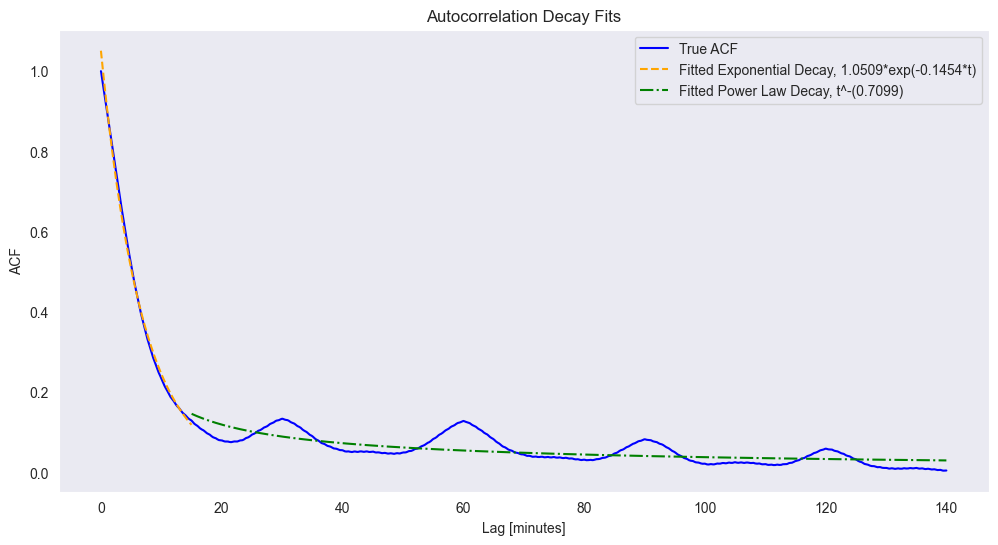

In [9]:
# Compute the ACF using the second-based data
acf_values = acf(df['Value'], nlags=8400)  # Adjust `nlags` to cover more minutes
lags = np.arange(len(acf_values)) / 60  # Convert lags from seconds to minutes

# Define the exponential decay function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Define the power-law decay function
def power_law_decay(x, a, b):
    return a / (1 + b * x)

def power_law_decay_simple(x, a):
    return x**(-a)

# Estimate parameters for the first strong decay (exponential)
# Fit the exponential decay to the first part of the ACF
strong_decay_indices = lags <= 15  # Fit for lags up to 6 minutes, determined by np.argmin(acf_values[:15*60])=331
popt_exp, pcov_exp = curve_fit(exponential_decay, lags[strong_decay_indices], acf_values[strong_decay_indices], p0=(1, 1/60))

# Estimate parameters for the second, longer decay (power-law)
# Fit the power-law decay to the longer tail of the ACF
longer_decay_indices = lags > 15  # Fit for lags beyond 20 minutes
popt_power, pcov_power = curve_fit(power_law_decay_simple, lags[longer_decay_indices], acf_values[longer_decay_indices], p0=(1))

# Extract standard errors (sqrt of diagonal of covariance matrix)
perr_exp = np.sqrt(np.diag(pcov_exp))
perr_power = np.sqrt(np.diag(pcov_power))

# Print the estimated parameters with uncertainties
print(f"Exponential Decay Parameters:")
print(f"  a = {popt_exp[0]:.4f} ± {perr_exp[0]:.4f}")
print(f"  b = {popt_exp[1]:.4f} ± {perr_exp[1]:.4f}")
print(f"Power Law Decay Parameter:")
print(f"  a = {popt_power[0]:.4f} ± {perr_power[0]:.4f}")


# Print the estimated parameters
print(f"Exponential Decay Parameters: a = {popt_exp[0]:.4f}, b = {popt_exp[1]:.4f}")
# print(f"Power Law Decay Parameters: a = {popt_power[0]:.4f}, b = {popt_power[1]:.4f}")
print(f"Power Law Decay Parameter: a = {popt_power[0]:.4f}")
H = (-popt_power[0] + 2)/2

# Visualize the fits
plt.figure(figsize=(12, 6))

# Plot the ACF
plt.plot(lags, acf_values, label='True ACF', color='blue')

# Plot the fitted exponential decay
plt.plot(lags[strong_decay_indices], exponential_decay(lags[strong_decay_indices], *popt_exp),
         label=f'Fitted Exponential Decay, {popt_exp[0]:.4f}*exp(-{popt_exp[1]:.4f}*t)', linestyle='--', color='orange')

# Plot the fitted power-law decay
plt.plot(lags[longer_decay_indices], power_law_decay_simple(lags[longer_decay_indices], *popt_power),
         label=f'Fitted Power Law Decay, t^-({popt_power[0]:.4f})', linestyle='-.', color='green')

#f'Fitted Power Law Decay, {popt_power[0]:.4f} / (1 + {popt_power[1]:.4f}*x)'

# Label the plot
plt.xlabel('Lag [minutes]')
plt.ylabel('ACF')
plt.grid()
plt.title('Autocorrelation Decay Fits')
plt.legend()
plt.show()

In [14]:
# --- Model Parameters from Table II ---
gamma1 = 1 / 950      # Damping within deadband
gamma2 = 1 / 400      # Damping outside deadband
omega_db = 0.028      # Deadband threshold (Hz)
print("H", H)              # Hurst exponent
alpha = 1.975         # Tail exponent for Lévy distribution
sigma = np.std(df['Value'])        # Scale of fluctuations (empirical std dev)
print("sigma: ", sigma)
trunc = 1.0           # Truncate extremes of Lévy
dt = 1                # Time step (in seconds)
T = 3600              # Total simulation time in seconds
N = int(T / dt)       # Number of steps


H 0.75
sigma:  0.07524611427543379


In [ ]:
plt.figure(figsize=(8, 5))

# Plot the PDF of the data
counts, bin_edges = np.histogram(df['Value'], bins=1000, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, counts, label='PDF', alpha=0.5)

mu, sigma = df['Value'].mean(), df['Value'].std()
x = np.linspace(df['Value'].min(), df['Value'].max(), 1000)

for alpha in [1.5, 1.7, 1.95]:
	flm_array = flm(H, alpha, 10000, trunc, sigma)
	# Generate FLM Fit data
	flm_data = [elt + mu for elt in flm_array]
	flm_counts, flm_bin_edges = np.histogram(flm_data, bins=100, density=True)
	flm_bin_centers = 0.5 * (flm_bin_edges[:-1] + flm_bin_edges[1:])
	plt.scatter(flm_bin_centers, flm_counts, label=f'FLM Fit alpha = {alpha}, H = {H}')

# Use a log scale for the y-axis
plt.yscale('log')

# plt.xlim(49.8, 50.2)
# Labels and legend
plt.xlabel('Grid frequency [Hz]')
plt.ylabel('PDF')
plt.title(f'Histogram (PDF) of the GB grid frequency, trunc={trunc}')
plt.legend()
plt.show()

sigma:  0.07524611427543379


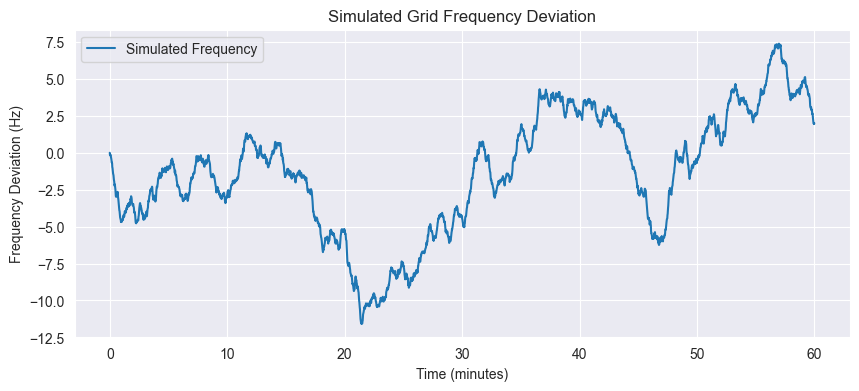

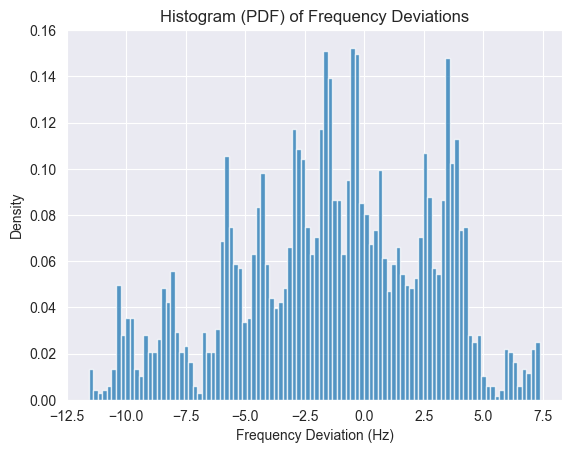

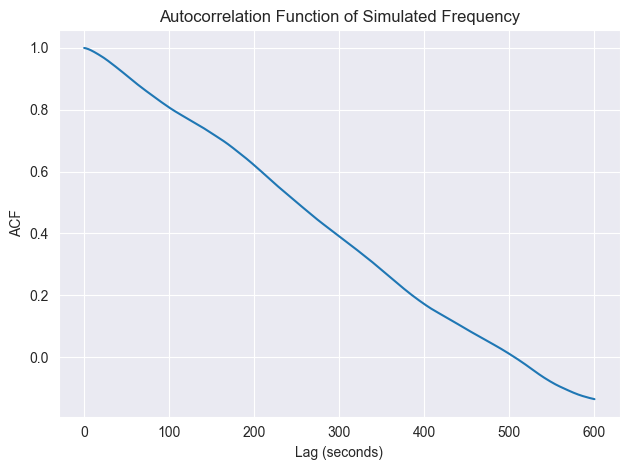

In [13]:
# --- Model Parameters from Table II ---
gamma1 = 1 / 950      # Damping within deadband
gamma2 = 1 / 400      # Damping outside deadband
omega_db = 0.028      # Deadband threshold (Hz)
print("H", H)              # Hurst exponent
alpha = 1.975         # Tail exponent for Lévy distribution
sigma = np.std(df['Value'])        # Scale of fluctuations (empirical std dev)
print("sigma: ", sigma)
trunc = 1.0           # Truncate extremes of Lévy
dt = 1                # Time step (in seconds)
T = 3600              # Total simulation time in seconds
N = int(T / dt)       # Number of steps

# --- Generate Fractional Lévy Noise ---
noise = flm(H=H, alpha=alpha, N=N, trunc=trunc, scale=sigma)

# --- Define γ_eff(ω) ---
def gamma_eff(omega):
    if -omega_db <= omega <= omega_db:
        return gamma1
    elif omega < -omega_db:
        return gamma2 + (gamma2 - gamma1) * omega_db / abs(omega)
    else:
        return gamma2 + (gamma1 - gamma2) * omega_db / abs(omega)

# --- Simulate the stochastic differential equation ---
omega = np.zeros(N)
for t in range(1, N):
    gamma = gamma_eff(omega[t-1])
    domega = -gamma * omega[t-1] * dt + noise[t]
    omega[t] = omega[t-1] + domega

# --- Plots ---
time = np.arange(N) * dt / 60  # in minutes

plt.figure(figsize=(10, 4))
plt.plot(time, omega, label='Simulated Frequency')
plt.title("Simulated Grid Frequency Deviation")
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency Deviation (Hz)")
plt.grid(True)
plt.legend()

plt.figure()
plt.hist(omega, bins=100, density=True, alpha=0.75)
plt.title("Histogram (PDF) of Frequency Deviations")
plt.xlabel("Frequency Deviation (Hz)")
plt.ylabel("Density")
plt.grid(True)

from statsmodels.tsa.stattools import acf
lags = 600
acf_vals = acf(omega, nlags=lags, fft=True)

plt.figure()
plt.plot(np.arange(lags+1), acf_vals)
plt.title("Autocorrelation Function of Simulated Frequency")
plt.xlabel("Lag (seconds)")
plt.ylabel("ACF")
plt.grid(True)

plt.tight_layout()
plt.show()